In [34]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Setup2 import * 
from Class_Structures import Room, Object, Region
from Region import * 

bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position = 0.3)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position = 0.4)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'south', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'north', position = 0.8)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'east', position = 0.6)
bedroom.draw()


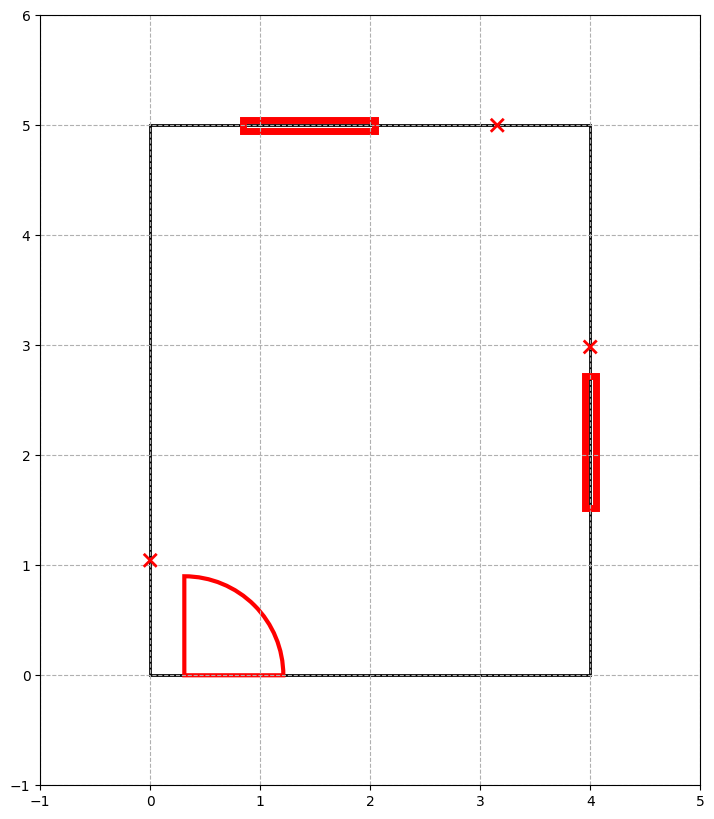

In [10]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key=api_key):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += " as well as the number of windows, doors, and socket. For each window, door, and socket tell me the dimensions (in meters),"
    prompt1 += " which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: "
    prompt1 += "{Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc." 
    prompt1 += "The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall. "
    prompt1 += "No other text please. Just the list with no commentary or explanation."
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")

    prompt2 = f"I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += "\n\n{file_contents}\n\n"
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3), kitchen.draw()."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function. The code should end with '.draw()'."
    prompt2 += file_contents

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        print(response_data2['choices'][0]['message']['content'])
        exec(response_data2['choices'][0]['message']['content'])
    else:
        print('Failed to get a response')
        print(response2.text)

    #exec(response_data2['choices'][0]['message']['content'])

    return response1, response2

#scene_descriptor = 'a bedroom for a teenager. The room is 4 meters wide and 6 meters long. There is one big window, 1 door, and 2 electrical plugs. The door should be on the far corner of the south wall.'   
scene_descriptor = "a bedroom for a teenage girl who plays the guitar."
response1, response2 = room_setup(scene_descriptor)

In [35]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

prompt3 = "Interior designers suggest that rooms should have distinct regions in them for different functions. Given the description:"
prompt3 += scene_descriptor
prompt3 += ", what regions should this room have? Pick a reasonable number of these for this room (ensure that the most important are included)"
prompt3 += " and return them in a simple list. For example if the scene description was 'An open plan kitchen dining room', the output would be "
prompt3 += "'cooking region, dining region, cleaning region' etc. Please give no other text."

response3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt3}],
        max_tokens=500
    )

print(response3.choices[0].message.content)

prompt4 = "For each region in the room described as: " + scene_descriptor + "with regions: " + response3.choices[0].message.content + ", give me all of the constraints/considerations on its position within the room."
prompt4 += " These constraints should depend on the physical features of the room like the windows, doors, plugs, etc."
prompt4 += " They should also depend on the other regions. For example, the constraints might be something like"
prompt4 += " 'the cooking region should be near the dining region' or 'the sleeping region should have a plug in it'"
prompt4 += " or 'the storage region should be against a wall'. Also, if there should be a focal point in the room, decide which region should include the focal point and add that as a constraint. There are many options. Return a list of these, and keep each"
prompt4 += " constraint/consideration short and simple, but make sure that you include all of the necessary considerations for"
prompt4 += " functionality as well as any design princples you think are important. Give no other text, only the list. Remove any reasoning"
prompt4 += " or explanation for the constraint/consideration. Instead of 'Sleeping region should be near an electrical plug for a bedside lamp or charging devices'"
prompt4 += " just say 'Sleeping region should be near a plug'."

response4 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt4}],
        max_tokens=500
    )

prompt5 = "Given the room so far: " + response2.json()['choices'][0]['message']['content'] + ", and the regions: " + response3.choices[0].message.content
prompt5 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0)."
prompt5 += " End with something like kitchen.draw(draw_regions = True). No other text please, only the python script."
prompt5 += file_contents
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()
    print(response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content'])
    #exec(response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content'])
else:
    print('Failed to get a response')
    print(response5.text)

sleeping region, study region, music practice region, relaxation region, storage region
bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position = 0.3)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position = 0.4)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'south', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'north', position = 0.8)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'east', position = 0.6)
bedroom.draw()
# Creating the Room
bedroom = create_room(4, 5)

# Setting up fixed objects
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position = 0.3)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position = 0.4)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'south', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'north',

# Creating the Room
bedroom = create_room(4, 5)

# Setting up fixed objects
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position = 0.3)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position = 0.4)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'south', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'north', position = 0.8)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'east', position = 0.6)

# Drawing the Room
bedroom.draw()

# Setting up regions
sleeping_region = region_setup(bedroom, 'sleeping', 0)
study_region = region_setup(bedroom, 'study', 1)
music_practice_region = region_setup(bedroom, 'music practice', 2)
relaxation_region = region_setup(bedroom, 'relaxation', 3)
storage_region = region_setup(bedroom, 'storage', 4)

# Drawing the Room with Regions
bedroom.draw(draw_regions = True)

positions = np.zeros(2 * len(bedroom.regions))
for i in range(len(bedroom.

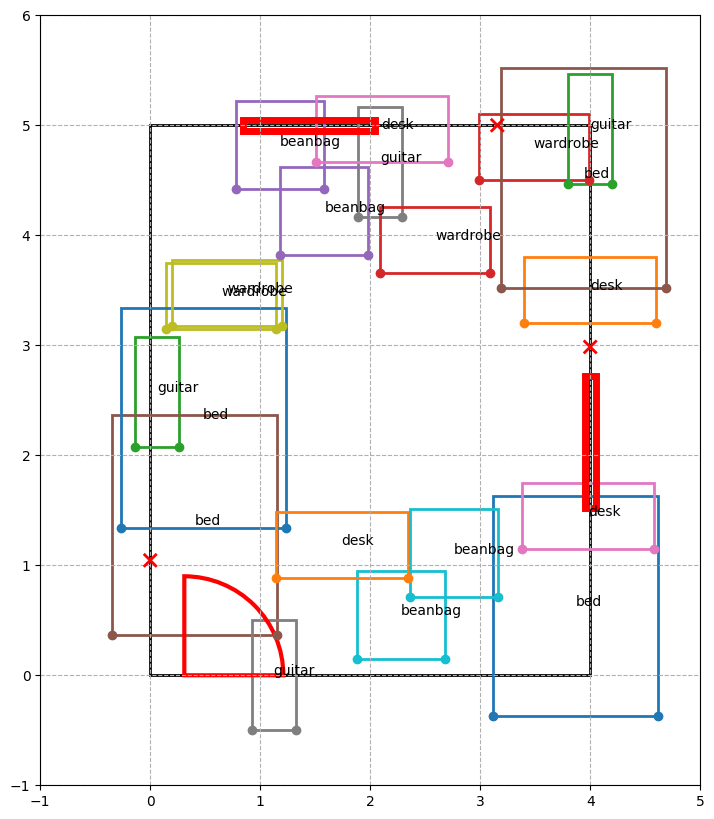

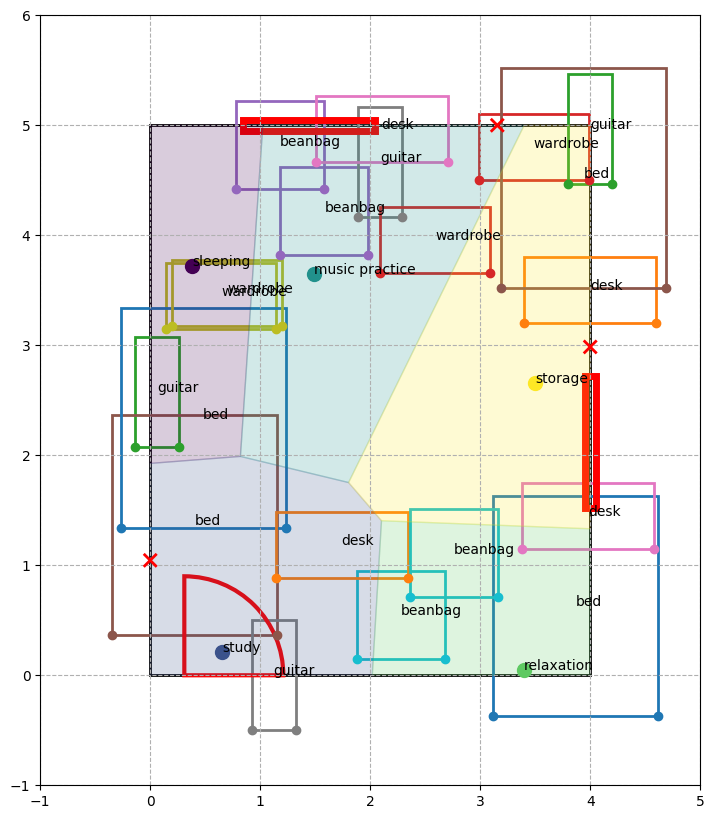

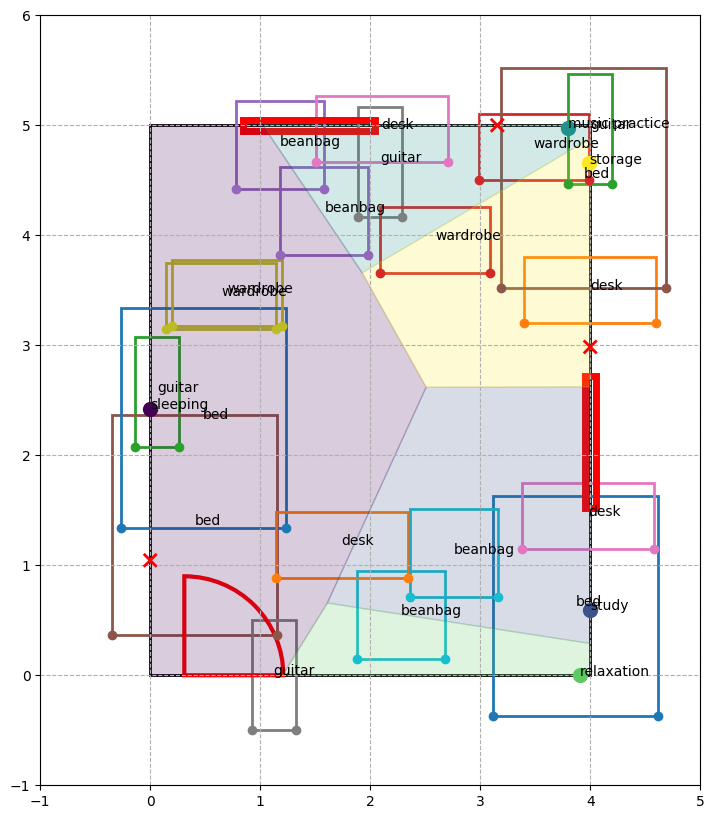

In [36]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
         }
# Read the contents of the .py file
file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Region.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()


prompt6 = "Given the room set up so far: " + response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content']
prompt6 += ", and the regions: " + response3.choices[0].message.content + " and the constraints: " + response4.choices[0].message.content
prompt6 += " . Using the script attached, transform each constraint into a function call that will ensure that the regions are set up correctly. Match each constraint"
prompt6 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out."
prompt6 += file_contents2
prompt6 += ". Then, once each point has been transformed to a function call, I then want the output to begin with the room set up, followed by: "
prompt6 += "positions = np.zeros(2*len(room.regions)) \n for i in range(len(room.regions)): \n positions[2*(room.regions[i].index)] = room.regions[i].x"
prompt6 +=  "\n positions[2*(room.regions[i].index) + 1] = room.regions[i].y (where 'room' is replaced by whatever the room name is)"
prompt6 += "\n def optimize_regions(positions, room): \n output = 0, followed by each constraint added to the ouput, and then the output returned."
prompt6 += "Finally, add this at the end (replacing 'room' with the name of the room): "
prompt6 += "bounds = Bounds([0] * 2 * len(room.regions), [room.width, room.length] * len(room.regions)) \n"
prompt6 += "res = minimize(optimize_regions, positions, args = (room), method = 'Nelder-Mead', bounds=bounds) \n"
prompt6 += "for i in range(len(room.regions)): \n room.regions[i].x, room.regions[i].y = res.x[2*(room.regions[i].index):2*(room.regions[i].index) + 2] \n"
prompt6 += "room.draw(draw_regions = True)"
prompt6 += "No extra text please, only the functions and the output. Don't have 'python' at the start of the code."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:
    response_data6 = response6.json()
    print(response6.json()['choices'][0]['message']['content'])
    exec(response6.json()['choices'][0]['message']['content'])
else:
    print('Failed to get a response')
    print(response6.text)

In [14]:
fixed_objects = ""
for i in range(len(bedroom.fixed_objects)):
    if i < len(bedroom.fixed_objects) - 1:
        fixed_objects += bedroom.fixed_objects[i].name + ", "
    else: 
        fixed_objects += bedroom.fixed_objects[i].name + "."
print(fixed_objects)
bedroom_width = bedroom.width
bedroom_length = bedroom.length

region_names = ""
for i in range(len(bedroom.regions)):
    if i < len(bedroom.regions) - 1:
        region_names += bedroom.regions[i].name + ", "
    else: 
        region_names += bedroom.regions[i].name + "."
print(region_names)

door, window, window, socket, socket.
sleeping, study, music, storage, relaxation.


In [24]:
prompt7 = "I am going to give you a description of a room, as well as all the fixed objects inside it (e.g. windows) and the dimensions of the room."
prompt7 += " I am also going to give you the different regions for the room. Based on this information, I want returned the most important object for each region,"
prompt7 += " and the dimensions for that object in meters. This should include width and length, not height. The room description is: "
prompt7 += scene_descriptor + ", and the regions are: " + region_names + ". The fixed objects are: " + fixed_objects
prompt7 += " Finally, the room dimensions are, width : " + str(bedroom_width) + " meters, and length : " + str(bedroom_length) + " meters."
prompt7 += "Please return it in the format of {object_name: name, object_width: width, object_length: length, region: region_name}. After the list, I also want you to give me all the constraints for each object"
prompt7 += " that depend on the items in the room. For example if an object should be against a wall, far away from a window, or near a socket. Give these as simply as possible, in the following format:  "
prompt7 += "{object_name: name, constraints: [constraint1, constraint2, ...]}. Give no other text in the response."

response7 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt7}],
        max_tokens=500
    )

print(response7.choices[0].message.content)

headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
         }
# Read the contents of the .py file
file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup2.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

[
    {object_name: bed, object_width: 1.5, object_length: 2, region: sleeping},
    {object_name: desk, object_width: 1.2, object_length: 0.6, region: study},
    {object_name: guitar, object_width: 0.4, object_length: 1, region: music},
    {object_name: wardrobe, object_width: 1, object_length: 0.6, region: storage},
    {object_name: beanbag, object_width: 0.8, object_length: 0.8, region: relaxation}
]

[
    {object_name: bed, constraints: [against_wall]},
    {object_name: desk, constraints: [near_socket, against_wall]},
    {object_name: guitar, constraints: [accessible_space]},
    {object_name: wardrobe, constraints: [against_wall]},
    {object_name: beanbag, constraints: []}
]


In [25]:
prompt8 = "Given this list of the objects: " + response7.choices[0].message.content.split("]")[0] + "], use the file attached (as well as the room code so far) to add the objects into the room with the correct parameters."
prompt8 += "The room code so far is: " + response6.json()['choices'][0]['message']['content']
prompt8 += " The region names are as follows: " + region_names
prompt8 += "The objects should be added in the correct regions. The code should end with 'room.draw(draw_regions = True)'."
prompt8 += "This is the file: " + file_contents3
prompt8 += "No extra text, only the functions and the output. Don't have 'python' at the start of the code."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt8}
            ]
    }
    
# Make the API call
response8 = requests.post(url, headers=headers, json=data)  
# Check the response
if response8.status_code == 200:
    response_data8 = response6.json()
    print(response8.json()['choices'][0]['message']['content'])
    #exec(response8.json()['choices'][0]['message']['content'])
else:
    print('Failed to get a response')
    print(response8.text)

# initialise the room
bedroom = create_room(4, 5)

# create the fixed objects
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position=0.3)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position=0.4)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'south', position=0.1)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'west', position=0.2)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'north', position=0.8)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'east', position=0.6)

# initialise the regions
sleeping_region = region_setup(bedroom, 'sleeping', 0)
study_region = region_setup(bedroom, 'study', 1)
music_region = region_setup(bedroom, 'music', 2)
dressing_region = region_setup(bedroom, 'dressing', 3)
storage_region = region_setup(bedroom, 'storage', 4)
relaxation_region = region_setup(bedroom, 'relaxation', 5)

# draw the room
bedroom.draw(draw_regions=True)

positions = np.zeros(2 * len(bedroom.regions))
for i in range(len(bedroom.regions)):
    positio

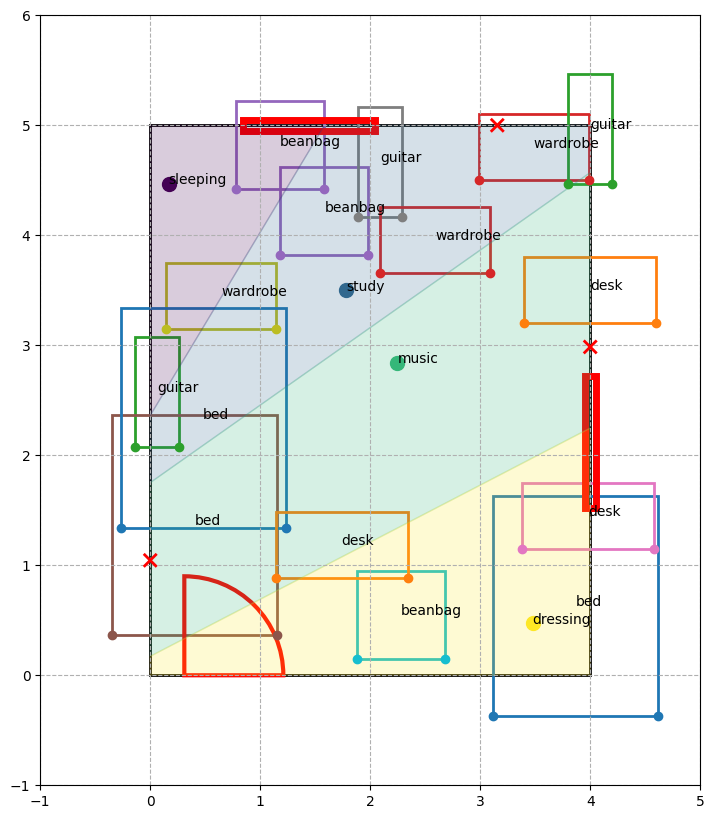

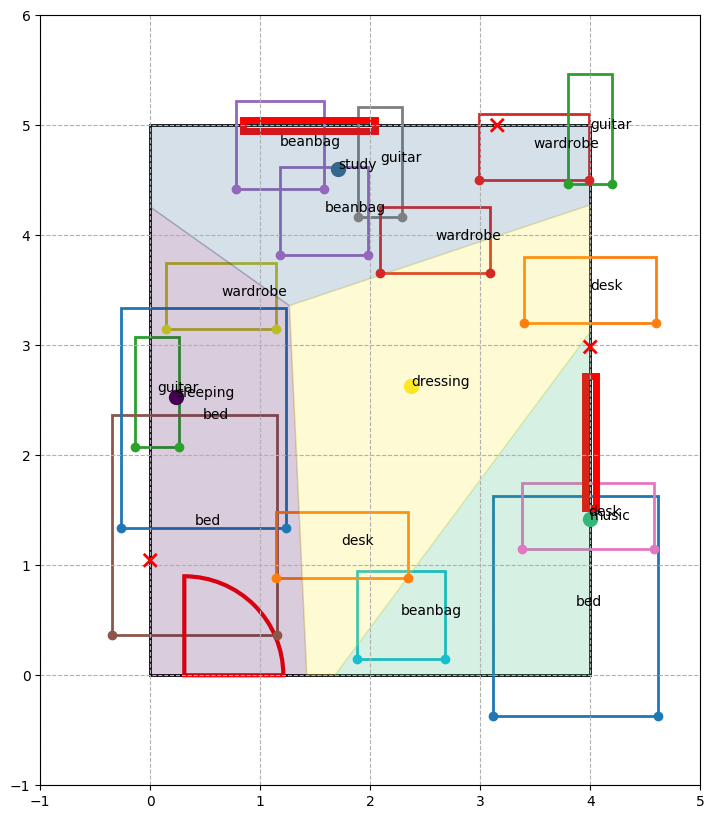

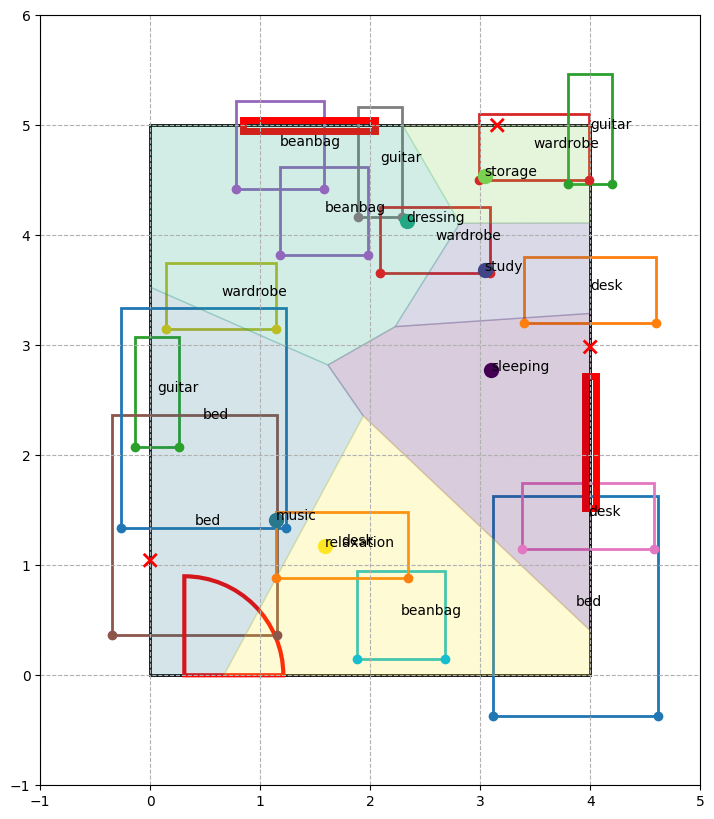

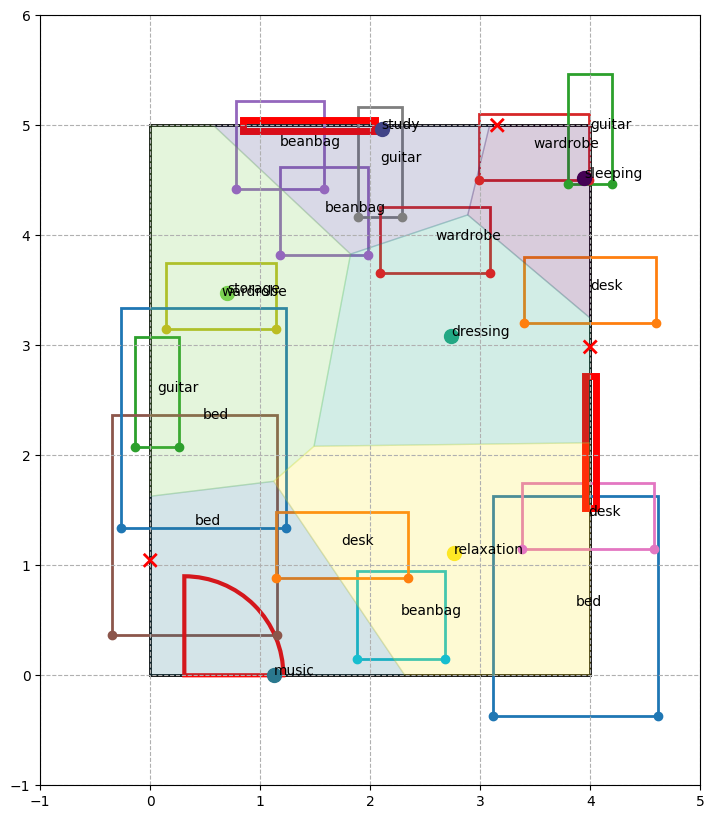

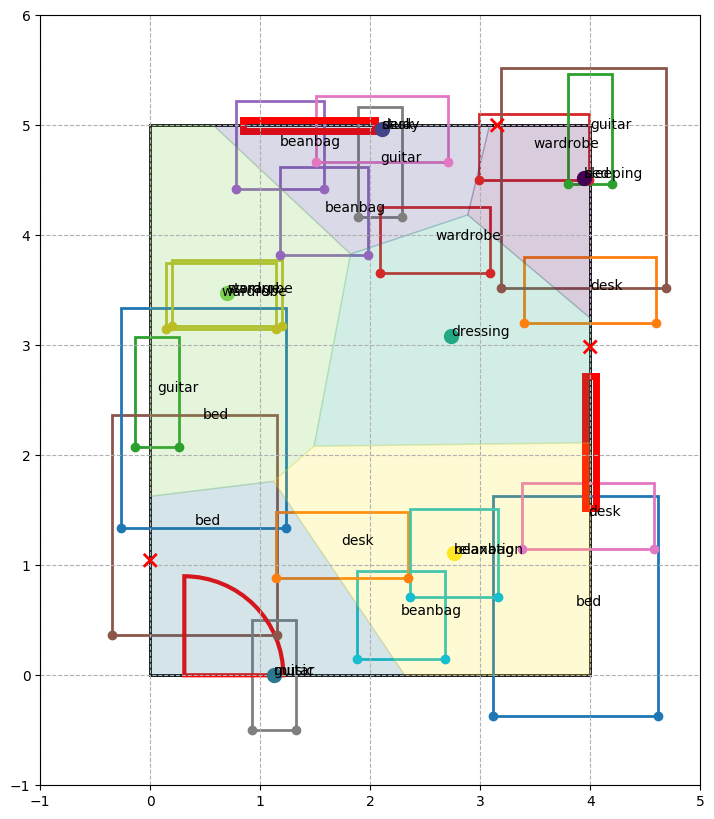

In [32]:
exec(response8.json()['choices'][0]['message']['content'])